In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import io
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

데이터 불러오기(온라인 쇼핑 플랫폼 고객들의 행동 데이터)
- BUY_CT_sum - 고객들의 일별 구매건수 합계
- HITS_SEQ_mean - 고객들의 일별 클릭수 평균
- TOT_SESS_HR_V_mean - 고객들의 일별 체류시간 평균
- CLNT_AGE_mean - 고객들의 일별 연령대 평균
- fashion - fashion 분야 네이버 데이터랩 쇼핑인사이트 클릭량 추이

In [ ]:
from google.colab import files
myfile = files.upload()

Saving Class9.csv to Class9.csv


In [ ]:
Class9 = pd.read_csv(io.BytesIO(myfile['Class9.csv']))
Class9.head()

,BUY_CT_sum,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,fashion
0,15446,107.008910,1958.732921,34.931247,383.777778
1,13338,91.290241,1738.117266,34.622027,356.888889
2,13514,94.545942,1776.986599,34.835746,349.555556
3,12405,88.670594,1651.527270,34.530426,339.777778
4,11739,90.039054,1731.360890,35.380734,325.111111


데이터테이블에 날짜(Date) 컬럼 추가

In [ ]:
Class9['Date'] = pd.date_range('2020-04-01', '2020-09-30').strftime('%Y-%m-%d')
Class9['Date'] = pd.to_datetime(Class9['Date'])
Class9 = Class9.set_index('Date')
Class9.head()

,BUY_CT_sum,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,fashion
Date,,,,,
2020-04-01,15446,107.008910,1958.732921,34.931247,383.777778
2020-04-02,13338,91.290241,1738.117266,34.622027,356.888889
2020-04-03,13514,94.545942,1776.986599,34.835746,349.555556
2020-04-04,12405,88.670594,1651.527270,34.530426,339.777778
2020-04-05,11739,90.039054,1731.360890,35.380734,325.111111


Y값 설정(BUT_CT_sum, 고객들의 일별 구매건수 합계)

In [ ]:
Y = Class9['BUY_CT_sum']

Modeling을 위한 Y값 제거 / 변수명 변경

In [ ]:
Class9.drop(columns=['BUY_CT_sum'],inplace=True)
Class9.rename(columns = {'fashion' : 'naver_click'}, inplace=True)
Class9.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,naver_click
Date,,,,
2020-04-01,107.008910,1958.732921,34.931247,383.777778
2020-04-02,91.290241,1738.117266,34.622027,356.888889
2020-04-03,94.545942,1776.986599,34.835746,349.555556
2020-04-04,88.670594,1651.527270,34.530426,339.777778
2020-04-05,90.039054,1731.360890,35.380734,325.111111


Data Scaling 함수 정의(Min-Max Scale)

In [ ]:
def minmax(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm

def inverse_minmax(norm,dataset):
    deNorm=norm*(dataset.max()-dataset.min())+dataset.min()
    return deNorm

Data Scaling

In [ ]:
scaled_df1=minmax(Class9)
#(xi–mean(x))/stdev(x)
scaled_df1.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,naver_click
Date,,,,
2020-04-01,0.560244,0.814391,0.369025,0.797101
2020-04-02,0.196711,0.378052,0.206432,0.637681
2020-04-03,0.272007,0.454928,0.318809,0.594203
2020-04-04,0.136125,0.206792,0.158267,0.536232
2020-04-05,0.167774,0.364689,0.605372,0.449275


In [ ]:
scaled_Y = minmax(Y)

scaled_df1 = pd.concat([scaled_df1, scaled_Y], axis = 1)
scaled_df1.rename(columns={'BUY_CT_sum':'Y'}, inplace=True)

scaled_df1.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,naver_click,Y
Date,,,,,
2020-04-01,0.560244,0.814391,0.369025,0.797101,0.962820
2020-04-02,0.196711,0.378052,0.206432,0.637681,0.785900
2020-04-03,0.272007,0.454928,0.318809,0.594203,0.800671
2020-04-04,0.136125,0.206792,0.158267,0.536232,0.707595
2020-04-05,0.167774,0.364689,0.605372,0.449275,0.651700


Modeling 함수 정의(Sequence 고려한 RNN-LSTM 모델)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

EDA(변수별 추세확인)

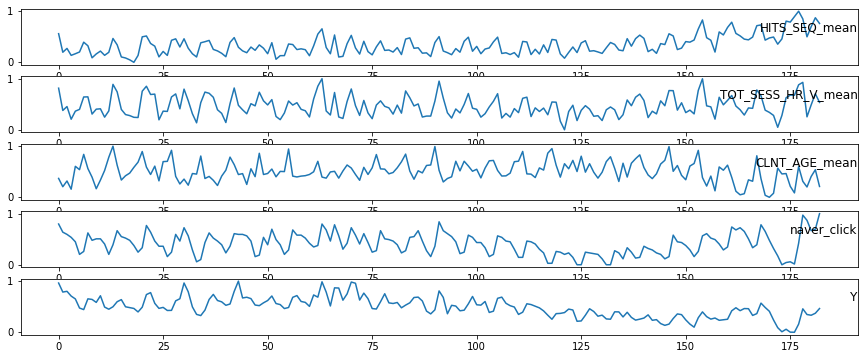

In [ ]:
#Plot of all variables
values = scaled_df1.values
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
plt.figure(figsize=(15,6))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(scaled_df1.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [ ]:
#scaled_data : scaling한 데이터. 사용하려는 변수 + 마지막 칼럼은 Y
#n : 사용하는 변수 개수

scaled_data = scaled_df1
n = 4

Data 분할(Train set:Test set=8:2)


In [ ]:
scaled_Y = scaled_data['Y']

values = scaled_df1.values
# frame as supervised learning
reframed = series_to_supervised(scaled_df1, 1, 1)
reframed.drop(reframed.columns[-(n+1):-1], axis=1,inplace = True)

# split into train and test sets
values = reframed.values
n_train = int(len(scaled_data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

LSTM Modeling

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.add(Dropout(0.15))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=350, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/350
3/3 - 19s - loss: 0.3180 - val_loss: 0.0918
Epoch 2/350
3/3 - 0s - loss: 0.2916 - val_loss: 0.0783
Epoch 3/350
3/3 - 0s - loss: 0.2675 - val_loss: 0.0661
Epoch 4/350
3/3 - 0s - loss: 0.2379 - val_loss: 0.0551
Epoch 5/350
3/3 - 0s - loss: 0.2179 - val_loss: 0.0453
Epoch 6/350
3/3 - 0s - loss: 0.1848 - val_loss: 0.0367
Epoch 7/350
3/3 - 0s - loss: 0.1680 - val_loss: 0.0293
Epoch 8/350
3/3 - 0s - loss: 0.1627 - val_loss: 0.0234
Epoch 9/350
3/3 - 0s - loss: 0.1438 - val_loss: 0.0189
Epoch 10/350
3/3 - 0s - loss: 0.1314 - val_loss: 0.0158
Epoch 11/350
3/3 - 0s - loss: 0.1091 - val_loss: 0.0141
Epoch 12/350
3/3 - 0s - loss: 0.0974 - val_loss: 0.0136
Epoch 13/350
3/3 - 0s - loss: 0.0944 - val_loss: 0.0144
Epoch 14/350
3/3 - 0s - loss: 0.0824 - val_loss: 0.0163
Epoch 15/350
3/3 - 0s - loss: 0.0879 - val_loss: 0.0192
Epoch 16/350
3/3 - 0s - loss: 0.0795 - val_loss: 0.0227
Epoch 17/350
3/3 - 0s - loss: 0.0712 - val_loss: 0.0266
Epoch 18/350
3/3 - 0s - loss: 0.0724 - val_loss: 0.0307


loss 비교 그래프

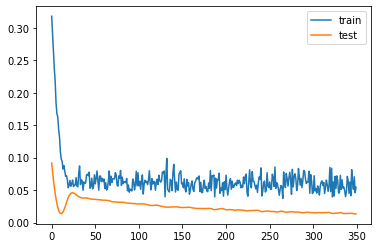

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

모델 검증(RMSE)

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
true_Y = Y.values[n_train+1:].reshape(yhat.shape[0],1)

In [ ]:
# invert scaling for forecast
dfhat = np.concatenate((true_Y,yhat), axis = 1)
#inv_dfhat = scaler.inverse_transform(dfhat)
inv_yhat = inverse_minmax(dfhat[:,1],dfhat[:,0])

# calculate RMSE
rmse = np.sqrt(mean_squared_error(true_Y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1616.315


실제 값 vs 예측 값 비교 그래프

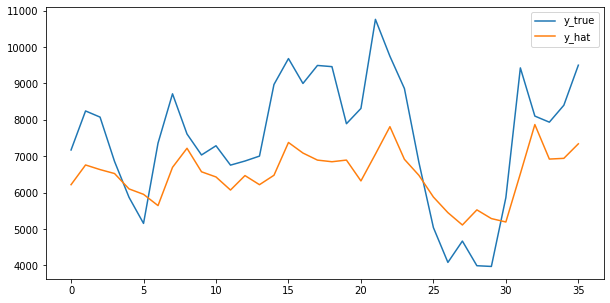

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(true_Y, label = 'y_true')
plt.plot(inv_yhat,label = 'y_hat')
plt.legend()

In [ ]:
inv_yhat = pd.Series(inv_yhat)
inv_yhat.index = Y[n_train+1:,].index

In [ ]:
inv_yhat.index

DatetimeIndex(['2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30', '2020-08-31', '2020-09-01', '2020-09-02',
               '2020-09-03', '2020-09-04', '2020-09-05', '2020-09-06',
               '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14',
               '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18',
               '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-26',
               '2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

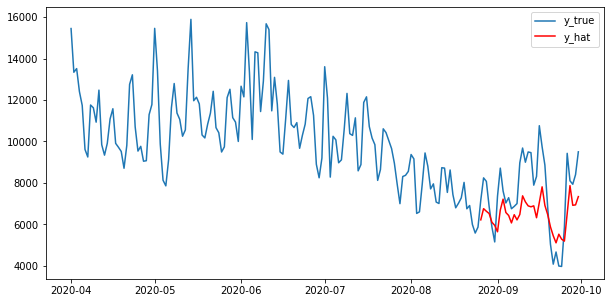

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(Y, label = 'y_true')
plt.plot(inv_yhat,label = 'y_hat', c='r')
plt.legend()